In [1]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from numpy import newaxis
from PIL import Image
from tensorflow.keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

In [2]:
print("tensorflow version is "+ str(tf.__version__))
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(X_train.shape)

tensorflow version is 2.8.0
(60000, 28, 28)


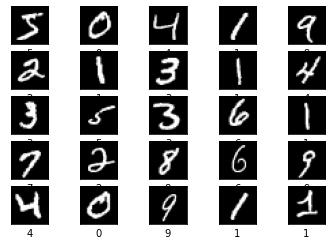

In [3]:
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap='gray')
  plt.xlabel(Y_train[i])
  plt.gray()
plt.show()

In [4]:
unique_train,frequency_train=np.unique(Y_train,return_counts=True)
total=np.sum(frequency_train)
print("unique labels: {} \nFrequency of individual labels: {} \nTotal sum is: {}".format(unique_train,frequency_train,total))

unique labels: [0 1 2 3 4 5 6 7 8 9] 
Frequency of individual labels: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949] 
Total sum is: 60000


In [5]:
X_train=X_train/255
X_test=X_test/255
print(X_train.shape)

(60000, 28, 28)


In [6]:
np.reshape(X_train,(-1,28,28))
X_train=X_train[:,:,:,newaxis]
np.reshape(X_test,(-1,28,28,1))
X_test=X_test[:,:,:,newaxis]
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (60000, 28, 28, 1)
X_test shape:  (10000, 28, 28, 1)


In [7]:
Y_train=to_categorical(Y_train,num_classes=10)
Y_test=to_categorical(Y_test,num_classes=10)
print(Y_test)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.1)
np.reshape(X_val,(-1,28,28))
print("x_train: ",X_train.shape)
print("x_test: ",X_val.shape)
print("y_train: ",Y_train.shape)
print("y_test: ",Y_val.shape)

x_train:  (54000, 28, 28, 1)
x_test:  (6000, 28, 28, 1)
y_train:  (54000, 10)
y_test:  (6000, 10)


In [9]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='Same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="Same",activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation = "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation = "softmax"))


In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0

In [11]:
model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy","AUC"])
batch_size=32
epochs=20

In [12]:
class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('model_history.csv' in os.listdir(os.getcwd())):
      with open('model_history.csv','a') as f:
        y=csv.DictWriter(f,logs.keys())
        y.writeheader()

    with open('model_history.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)

In [13]:
%load_ext tensorboard

In [14]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist= model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val,Y_val),steps_per_epoch=1600//batch_size,callbacks=[StoreModelHistory(),tensorboard_callback])

Epoch 1/20
50/50 [==============================] - 42s 697ms/step - loss: 1.9520 - accuracy: 0.3344 - auc: 0.7457 - val_loss: 1.0945 - val_accuracy: 0.6915 - val_auc: 0.9590 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 34s 684ms/step - loss: 1.0069 - accuracy: 0.6631 - auc: 0.9429 - val_loss: 0.5025 - val_accuracy: 0.8778 - val_auc: 0.9895 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 34s 686ms/step - loss: 0.6862 - accuracy: 0.7850 - auc: 0.9715 - val_loss: 0.3643 - val_accuracy: 0.9010 - val_auc: 0.9929 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 33s 671ms/step - loss: 0.4905 - accuracy: 0.8431 - auc: 0.9843 - val_loss: 0.2500 - val_accuracy: 0.9290 - val_auc: 0.9960 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 34s 694ms/step - loss: 0.4235 - accuracy: 0.8744 - auc: 0.9871 - val_loss: 0.2379 - val_accuracy: 0.9315 - val_auc: 0.9959 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 33s 662m

In [15]:
print(hist.history)

{'loss': [1.9520013332366943, 1.0068608522415161, 0.6862261295318604, 0.4904980957508087, 0.4235343039035797, 0.4172755479812622, 0.3288399875164032, 0.2769579589366913, 0.2953653633594513, 0.24371759593486786, 0.24212855100631714, 0.23840223252773285, 0.24339693784713745, 0.22155490517616272, 0.17731788754463196, 0.16172577440738678, 0.18539845943450928, 0.17324571311473846, 0.17188388109207153, 0.177235946059227], 'accuracy': [0.3343749940395355, 0.6631249785423279, 0.7850000262260437, 0.8431249856948853, 0.8743749856948853, 0.8693749904632568, 0.8943750262260437, 0.9156249761581421, 0.9075000286102295, 0.9275000095367432, 0.9231250286102295, 0.9275000095367432, 0.9325000047683716, 0.9368749856948853, 0.9443749785423279, 0.9474999904632568, 0.9443749785423279, 0.9431250095367432, 0.949999988079071, 0.9462500214576721], 'auc': [0.7457081079483032, 0.9429442286491394, 0.9714639186859131, 0.9843193292617798, 0.9870638251304626, 0.9869963526725769, 0.9907426238059998, 0.9939903020858765,

In [16]:
img= np.ndarray('\cropped_images\image_1.png')
print(img.shape)
# np.reshape('\cropped_images\image_0.png',(-1,28,28))
# model.predict('\cropped_images\image_0.png')

TypeError: 'str' object cannot be interpreted as an integer

In [17]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 2024), started 11 days, 0:08:28 ago. (Use '!kill 2024' to kill it.)

In [21]:
img_path=r'C:\Users\Living Room\cropped_images\image_222.png'
img = tf.keras.utils.load_img(
    img_path, target_size=(28,28))
img = tf.image.rgb_to_grayscale(img)
#img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# image = plt.imread(r"C:\Users\Living Room\cropped_images\image_1.png")
# plt.imshow(image)

# image = tf.keras.preprocessing.image.load_img(img_path)
# input_arr = np.reshape(image, (28, 28, 1))
# # input_arr = tf.keras.preprocessing.image.img_to_array(image)
# # input_arr = np.array([input_arr])  # Convert single image to a batch.
# # input_arr = np.reshape(image, ( 28, 28, 1))
# predictions = model.predict(input_arr)

In [22]:
print(predictions,score)

[[0.09314416 0.10554881 0.09059423 0.10552547 0.09502737 0.094201
  0.09691347 0.09162628 0.12218219 0.105237  ]] tf.Tensor(
[0.09931251 0.10055211 0.09905959 0.10054977 0.09949971 0.09941752
 0.09968755 0.09916188 0.10223863 0.10052077], shape=(10,), dtype=float32)


In [23]:
x = np.argmax(predictions, axis=None, out=None)
print(x)

8


In [ ]:
import cv2 as cv
image = cv.imread('cropped_images\image_1.png')
plt.imshow(image)

In [ ]:
predictions = model.predict(input_arr)


In [ ]:
wtf = model.evaluate(X_test, Y_test)
print(wtf)

In [28]:
from PIL import Image, ImageChops

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
for i in range(1,37):
    path = 'cropped_images\image_'+ str(i)+'.png'
    im = Image.open(path)
    im = trim(im)
    im.show()